# Deep Learning
<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marcinsawinski/UEP_KIE_DL_CODE/blob/main/dl06_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>



https://www.kaggle.com/code/ahmedtronic/weather-conditions-classification-acc-97/notebook

https://www.tensorflow.org/api_docs/python/tf/keras/applications

https://keras.io/api/applications/#usage-examples-for-image-classification-models

https://keras.io/guides/transfer_learning/

https://arxiv.org/abs/1905.11946




In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [8]:
folds = os.listdir(data_dir)
folds.remove('.DS_Store')
folds

['Cloudy', 'Rain', 'Shine', 'Sunrise']

In [21]:
# Generate data paths with labels
data_dir = 'data/Multi-class Weather Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
folds.remove('.DS_Store')
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [25]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [31]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

test_batch_size  =1

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 900 validated image filenames belonging to 4 classes.
Found 112 validated image filenames belonging to 4 classes.
Found 113 validated image filenames belonging to 4 classes.


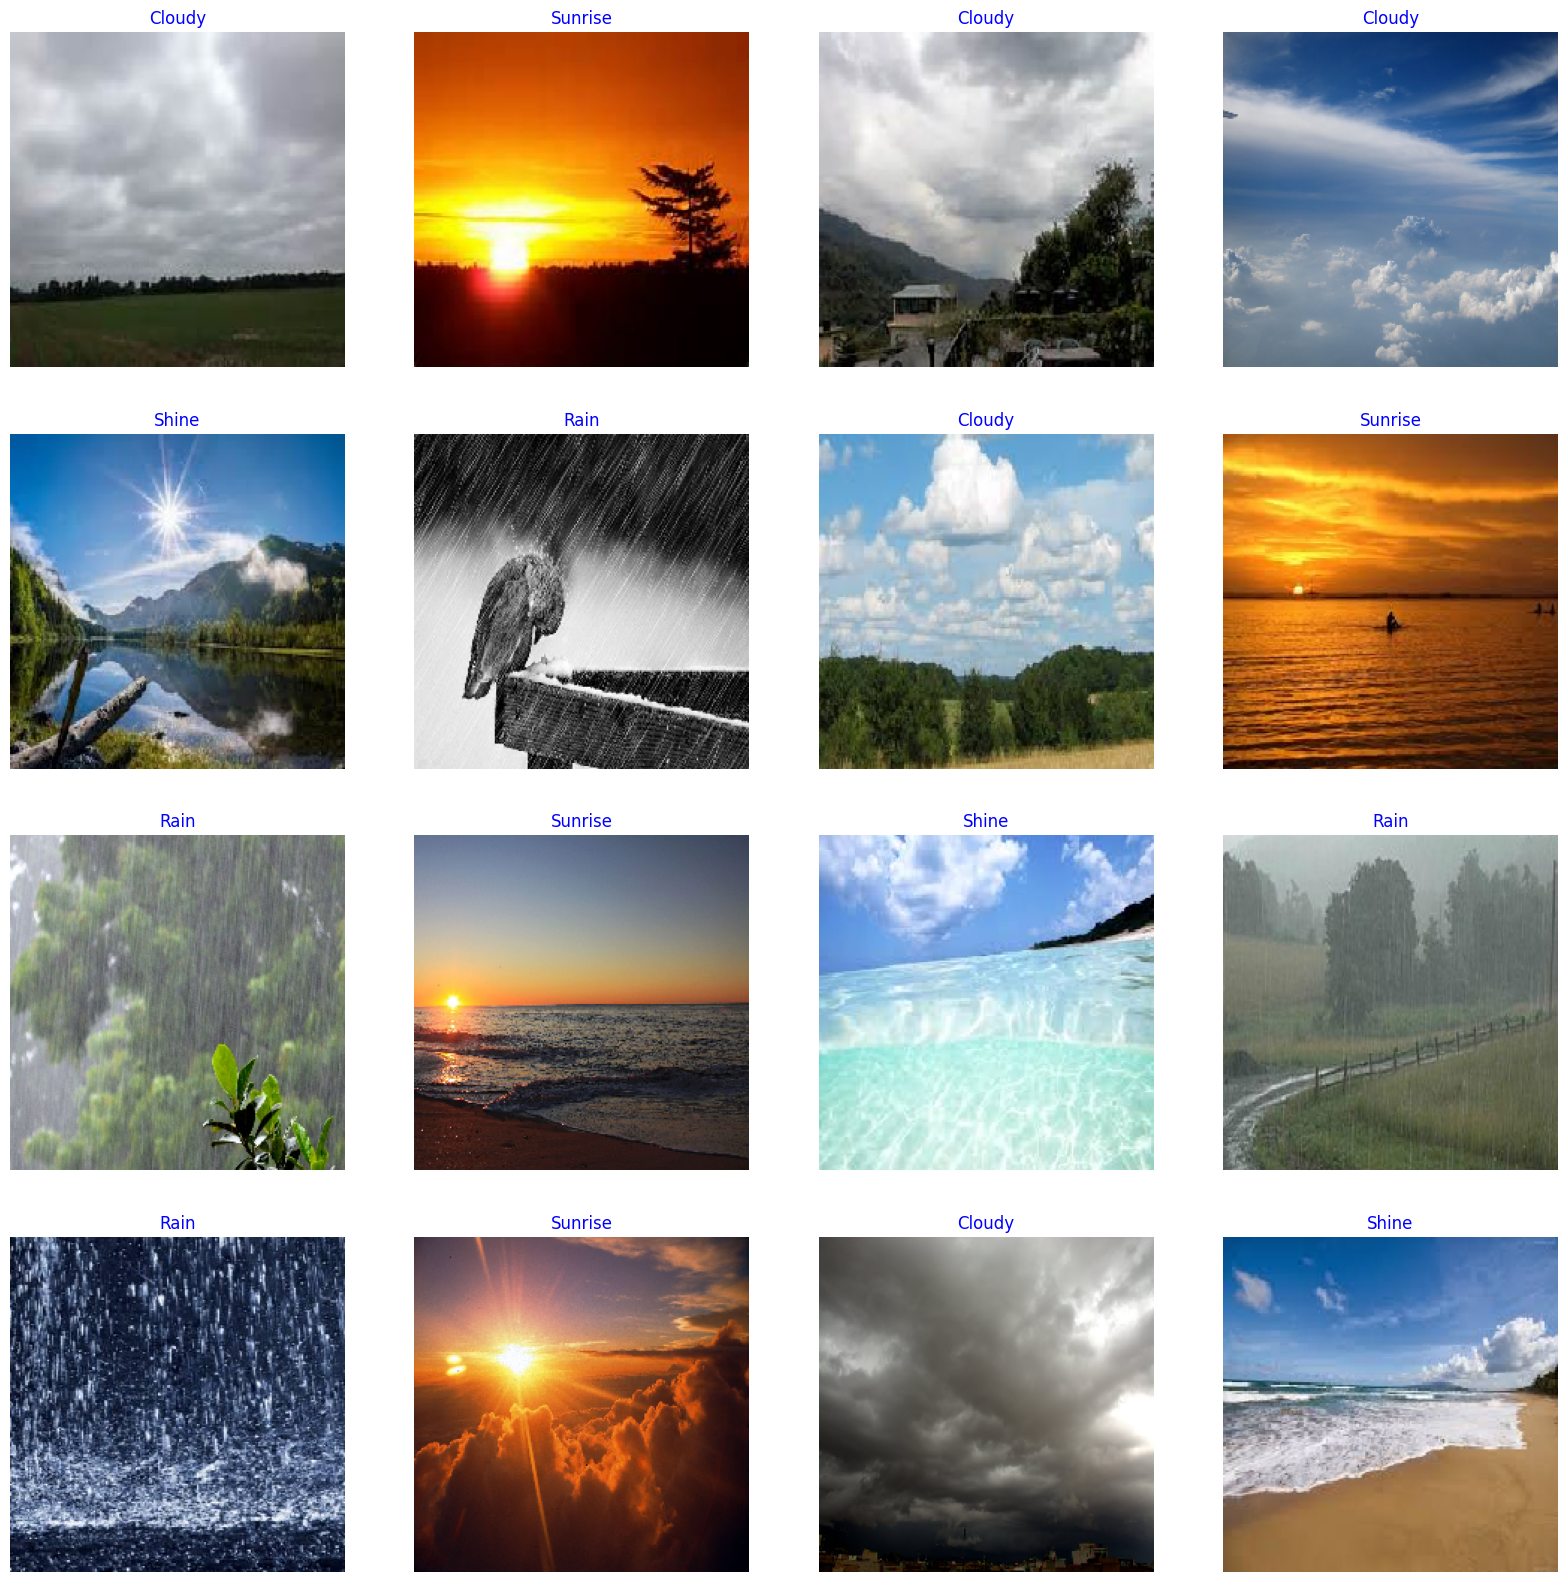

In [34]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size

plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [36]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [62]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model ,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_4 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 4,383,655
Trainable params: 4,339,072
Non

In [63]:
batch_size = 16
epochs = 60 

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, callbacks= [],
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/60
57/57 [==============================] - 41s 640ms/step - loss: 7.9324 - accuracy: 0.7756 - val_loss: 7.8457 - val_accuracy: 0.8571
Epoch 2/60
57/57 [==============================] - 36s 630ms/step - loss: 6.6808 - accuracy: 0.9444 - val_loss: 6.4899 - val_accuracy: 0.9286
Epoch 3/60
57/57 [==============================] - 36s 631ms/step - loss: 5.9297 - accuracy: 0.9633 - val_loss: 5.6693 - val_accuracy: 0.9464
Epoch 4/60
57/57 [==============================] - 36s 624ms/step - loss: 5.2840 - accuracy: 0.9700 - val_loss: 5.0469 - val_accuracy: 0.9375
Epoch 5/60
57/57 [==============================] - 36s 626ms/step - loss: 4.7539 - accuracy: 0.9622 - val_loss: 4.5402 - val_accuracy: 0.9464
Epoch 6/60
57/57 [==============================] - 36s 627ms/step - loss: 4.2997 - accuracy: 0.9656 - val_loss: 4.0821 - val_accuracy: 0.9375
Epoch 7/60
57/57 [==============================] - 40s 704ms/step - loss: 3.8581 - accuracy: 0.9767 - val_loss: 3.7013 - val_accuracy: 0.9554

2023-04-02 23:58:40.544718: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: 'data/Multi-class Weather Dataset/Rain/rain90.jpg'
Traceback (most recent call last):

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/Users/marcinsawinski/miniforge3/env

19/57 [=========>....................] - ETA: 24s - loss: 0.1541 - accuracy: 1.0000

UnknownError: Graph execution error:

FileNotFoundError: [Errno 2] No such file or directory: 'data/Multi-class Weather Dataset/Rain/rain90.jpg'
Traceback (most recent call last):

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/keras/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/Users/marcinsawinski/miniforge3/envs/hml3/lib/python3.9/site-packages/keras/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: 'data/Multi-class Weather Dataset/Rain/rain90.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_32161]